In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import evaluate
import gensim
import transformers
import nltk
import torch_geometric
import json
from xml.dom import minidom
from tqdm import tqdm

from modeling import testModel

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

c:\Users\wangz\anaconda3\envs\sp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# This cell makes sure modules are auto-loaded when you change external python files
%load_ext autoreload
%autoreload 2

In [3]:
from os import listdir
from os.path import isfile, join

mypath = "pants_straight_sides_1000"

onlyfiles_pants = [join(mypath,f, f + "_pattern.svg") for f in listdir(mypath) if not isfile(join(mypath, f))]

file_names_pants = [f for f in listdir(mypath) if not isfile(join(mypath, f))]

mypath = "skirt_2_panels_1200"

onlyfiles_skirt = [join(mypath,f, f + "_pattern.svg") for f in listdir(mypath) if not isfile(join(mypath, f))]

file_names_skirt = [f for f in listdir(mypath) if not isfile(join(mypath, f))]

In [4]:
len(file_names_skirt)

1200

In [5]:
def read_svg_string(svg_strings):
    edge_list = []
    edge_index = []
    ps = 0
    pe = 0

    panel_list = []

    for i in svg_strings:
        ps = pe
        tmp = i.split()
        prev_x = float(tmp[1])
        prev_y = float(tmp[2])
        j = 3
        while j < len(tmp):
            edge = [prev_x, prev_y]
            if tmp[j] == 'z':
                break

            if tmp[j] == 'L':
                edge.append(float(tmp[j+1]))
                edge.append(float(tmp[j+2]))
                prev_x = float(tmp[j+1])
                prev_y = float(tmp[j+2])
                edge.append((edge[0] + edge[2]) / 2)
                edge.append((edge[1] + edge[3]) / 2)
                j = j + 3
                pe += 1
                edge_list.append(edge)
                continue
            if tmp[j] == 'Q':
                prev_x = float(tmp[j+3])
                prev_y = float(tmp[j+4])
                edge.append(float(tmp[j+3]))
                edge.append(float(tmp[j+4]))
                edge.append(float(tmp[j+1]))
                edge.append(float(tmp[j+2]))
                j = j + 5
                pe += 1
                edge_list.append(edge)
                continue
        for j in range(ps, pe - 1):
            edge_index.append([j, j + 1])
        edge_index.append([pe - 1, ps])
        panel_list.append(pe - ps)

    return [edge_list,edge_index, panel_list]
            


In [6]:
def get_data_from_spec(file_path):
    doc = minidom.parse(file_path)  # parseString also exists
    path_strings = [path.getAttribute('d') for path
                in doc.getElementsByTagName('path')]
    return read_svg_string(path_strings)

In [7]:
data_pants = [get_data_from_spec(i) for i in onlyfiles_pants]
data_skirt = [get_data_from_spec(i) for i in onlyfiles_skirt]

train_data_pants = data_pants[100:]
test_data_pants = data_pants[:100]

train_data_skirt = data_skirt[100:]
test_data_skirt = data_skirt[:100]

train_data = train_data_pants + train_data_skirt
test_data = test_data_pants + test_data_skirt

In [23]:
name = "skirt_2_panels_1200\skirt_2_panels_0AG3RA5IMQ\skirt_2_panels_0AG3RA5IMQ_pattern.svg"
tmp = get_data_from_spec("skirt_2_panels_1200\skirt_2_panels_0AG3RA5IMQ\skirt_2_panels_0AG3RA5IMQ_pattern.svg")
tmp

[[[60.0, 285.0, 216.0, 285.0, 138.0, 318.53418917280607],
  [216.0, 285.0, 213.0, 105.0, 214.5, 195.0],
  [213.0, 105.0, 198.0, 60.0, 205.5, 82.5],
  [198.0, 60.0, 78.0, 60.0, 138.0, 72.0],
  [78.0, 60.0, 63.0, 105.0, 70.5, 82.5],
  [63.0, 105.0, 60.0, 285.0, 61.5, 195.0],
  [276.0, 285.0, 432.0, 285.0, 354.0, 207.76996717634685],
  [432.0, 285.0, 429.0, 105.0, 430.5, 195.0],
  [429.0, 105.0, 414.0, 60.0, 421.5, 82.5],
  [414.0, 60.0, 294.0, 60.0, 354.0, 72.0],
  [294.0, 60.0, 279.0, 105.0, 286.5, 82.5],
  [279.0, 105.0, 276.0, 285.0, 277.5, 195.0]],
 [[0, 1],
  [1, 2],
  [2, 3],
  [3, 4],
  [4, 5],
  [5, 0],
  [6, 7],
  [7, 8],
  [8, 9],
  [9, 10],
  [10, 11],
  [11, 6]]]

In [9]:
lr = 1e-3
num_epochs = 50

model = testModel(6).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [10]:
#training

model.train()

train_loss_list = []
eval_loss_list = []

for epoch in tqdm(range(num_epochs), leave=False, position=0):
    
    epoch_loss = 0
        
    for data in tqdm(train_data, leave=False, position=1):
        
        input_data = torch.tensor(data[0]).to(torch.float).to(device)
        edge_index = torch.tensor(data[1]).to(device).permute(1,0)
            
        # Forward pass
        out = model(input_data, edge_index)
        #print(decoder_outputs.size())
            
        

        # TODO: Compute loss
        loss = criterion(out, input_data)
        epoch_loss += loss.item()
            
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    
        

    print(f'Epoch {epoch + 1} | Train Loss: {(epoch_loss / len(train_data)):.4f}')
    train_loss_list.append(epoch_loss / len(train_data))
    #eval
    eval_loss = 0
    for data in  test_data:
        input_data = torch.tensor(data[0]).to(device)
        edge_index = torch.tensor(data[1]).to(device).permute(1,0)
            
        # Forward pass
        out = model(input_data, edge_index)
        #print(decoder_outputs.size())
            
        

        # TODO: Compute loss
        loss = criterion(out, input_data)
        eval_loss += loss.item()
    print(f'Epoch {epoch + 1} | Eval Loss: {(eval_loss / len(test_data)):.4f}')
    eval_loss_list.append(eval_loss / len(test_data))
        
        

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 30109.1134


  2%|▏         | 1/50 [00:20<16:58, 20.78s/it]

Epoch 1 | Eval Loss: 5548.7894


Epoch 2 | Train Loss: 3090.4312


  4%|▍         | 2/50 [01:00<25:38, 32.04s/it]

Epoch 2 | Eval Loss: 3276.3377


Epoch 3 | Train Loss: 1873.1177


  6%|▌         | 3/50 [01:22<21:16, 27.15s/it]

Epoch 3 | Eval Loss: 2446.8714


Epoch 4 | Train Loss: 1279.3485


  8%|▊         | 4/50 [01:45<19:35, 25.55s/it]

Epoch 4 | Eval Loss: 1740.5675


Epoch 5 | Train Loss: 923.9310


 10%|█         | 5/50 [02:07<18:19, 24.43s/it]

Epoch 5 | Eval Loss: 1448.8873


Epoch 6 | Train Loss: 727.4413


 12%|█▏        | 6/50 [02:27<16:53, 23.03s/it]

Epoch 6 | Eval Loss: 1146.0563


Epoch 7 | Train Loss: 601.8061


 14%|█▍        | 7/50 [02:48<15:51, 22.14s/it]

Epoch 7 | Eval Loss: 1132.3901


Epoch 8 | Train Loss: 506.9702


 16%|█▌        | 8/50 [03:08<14:59, 21.41s/it]

Epoch 8 | Eval Loss: 832.0585


Epoch 9 | Train Loss: 444.1565


 18%|█▊        | 9/50 [03:28<14:19, 20.96s/it]

Epoch 9 | Eval Loss: 720.3332


Epoch 10 | Train Loss: 387.9562


 20%|██        | 10/50 [03:48<13:47, 20.69s/it]

Epoch 10 | Eval Loss: 755.8167


Epoch 11 | Train Loss: 343.2037


 22%|██▏       | 11/50 [04:07<13:16, 20.42s/it]

Epoch 11 | Eval Loss: 726.7722


Epoch 12 | Train Loss: 316.6912


 24%|██▍       | 12/50 [04:28<12:57, 20.46s/it]

Epoch 12 | Eval Loss: 708.7673


Epoch 13 | Train Loss: 286.2314


 26%|██▌       | 13/50 [04:48<12:30, 20.29s/it]

Epoch 13 | Eval Loss: 709.3541


Epoch 14 | Train Loss: 269.7263


 28%|██▊       | 14/50 [05:08<12:07, 20.20s/it]

Epoch 14 | Eval Loss: 690.1216


Epoch 15 | Train Loss: 258.4183


 30%|███       | 15/50 [05:29<11:51, 20.34s/it]

Epoch 15 | Eval Loss: 642.3159


Epoch 16 | Train Loss: 241.1489


 32%|███▏      | 16/50 [05:48<11:26, 20.18s/it]

Epoch 16 | Eval Loss: 730.1649


Epoch 17 | Train Loss: 226.8518


 34%|███▍      | 17/50 [06:08<11:02, 20.06s/it]

Epoch 17 | Eval Loss: 556.6745


Epoch 18 | Train Loss: 214.8659


 36%|███▌      | 18/50 [06:28<10:40, 20.01s/it]

Epoch 18 | Eval Loss: 551.3744


Epoch 19 | Train Loss: 201.6770


 38%|███▊      | 19/50 [06:48<10:20, 20.02s/it]

Epoch 19 | Eval Loss: 521.1505


Epoch 20 | Train Loss: 196.2964


 40%|████      | 20/50 [07:08<10:00, 20.02s/it]

Epoch 20 | Eval Loss: 499.3336


Epoch 21 | Train Loss: 186.9842


 42%|████▏     | 21/50 [07:28<09:41, 20.06s/it]

Epoch 21 | Eval Loss: 469.7761


Epoch 22 | Train Loss: 180.1213


 44%|████▍     | 22/50 [07:48<09:21, 20.07s/it]

Epoch 22 | Eval Loss: 488.6428


Epoch 23 | Train Loss: 171.4155


 46%|████▌     | 23/50 [08:08<09:01, 20.07s/it]

Epoch 23 | Eval Loss: 480.5086


Epoch 24 | Train Loss: 161.5951


 48%|████▊     | 24/50 [08:28<08:41, 20.07s/it]

Epoch 24 | Eval Loss: 477.5735


Epoch 25 | Train Loss: 162.0722


 50%|█████     | 25/50 [08:49<08:24, 20.16s/it]

Epoch 25 | Eval Loss: 533.4065


Epoch 26 | Train Loss: 159.0181


 52%|█████▏    | 26/50 [09:09<08:04, 20.20s/it]

Epoch 26 | Eval Loss: 479.8208


Epoch 27 | Train Loss: 156.1827


 54%|█████▍    | 27/50 [09:30<07:50, 20.46s/it]

Epoch 27 | Eval Loss: 484.9897


Epoch 28 | Train Loss: 151.1864


 56%|█████▌    | 28/50 [09:50<07:27, 20.34s/it]

Epoch 28 | Eval Loss: 441.7307


Epoch 29 | Train Loss: 146.6330


 58%|█████▊    | 29/50 [10:10<07:03, 20.16s/it]

Epoch 29 | Eval Loss: 391.2959


Epoch 30 | Train Loss: 140.6345


 60%|██████    | 30/50 [10:30<06:41, 20.10s/it]

Epoch 30 | Eval Loss: 473.0352


Epoch 31 | Train Loss: 136.5596


 62%|██████▏   | 31/50 [10:50<06:21, 20.09s/it]

Epoch 31 | Eval Loss: 430.1897


Epoch 32 | Train Loss: 137.0779


 64%|██████▍   | 32/50 [11:10<06:02, 20.14s/it]

Epoch 32 | Eval Loss: 439.8934


Epoch 33 | Train Loss: 129.0828


 66%|██████▌   | 33/50 [11:30<05:41, 20.07s/it]

Epoch 33 | Eval Loss: 391.6692


Epoch 34 | Train Loss: 126.3745


 68%|██████▊   | 34/50 [11:50<05:19, 19.99s/it]

Epoch 34 | Eval Loss: 399.4046


Epoch 35 | Train Loss: 121.1956


 70%|███████   | 35/50 [12:10<04:58, 19.92s/it]

Epoch 35 | Eval Loss: 492.1772


Epoch 36 | Train Loss: 119.2560


 72%|███████▏  | 36/50 [12:30<04:38, 19.89s/it]

Epoch 36 | Eval Loss: 409.8904


Epoch 37 | Train Loss: 118.1876


 74%|███████▍  | 37/50 [12:49<04:18, 19.89s/it]

Epoch 37 | Eval Loss: 406.7461


Epoch 38 | Train Loss: 115.3988


 76%|███████▌  | 38/50 [13:09<03:58, 19.87s/it]

Epoch 38 | Eval Loss: 395.4662


Epoch 39 | Train Loss: 114.4127


 78%|███████▊  | 39/50 [13:29<03:38, 19.84s/it]

Epoch 39 | Eval Loss: 387.0433


Epoch 40 | Train Loss: 114.2466


 80%|████████  | 40/50 [13:49<03:18, 19.80s/it]

Epoch 40 | Eval Loss: 379.5200


Epoch 41 | Train Loss: 107.5816


 82%|████████▏ | 41/50 [14:08<02:57, 19.76s/it]

Epoch 41 | Eval Loss: 369.6870


Epoch 42 | Train Loss: 106.6033


 84%|████████▍ | 42/50 [14:29<02:38, 19.87s/it]

Epoch 42 | Eval Loss: 301.8683


Epoch 43 | Train Loss: 107.2683


 86%|████████▌ | 43/50 [14:48<02:19, 19.86s/it]

Epoch 43 | Eval Loss: 377.6265


Epoch 44 | Train Loss: 108.0409


 88%|████████▊ | 44/50 [15:08<01:58, 19.82s/it]

Epoch 44 | Eval Loss: 338.7081


Epoch 45 | Train Loss: 100.8363


 90%|█████████ | 45/50 [15:28<01:39, 19.83s/it]

Epoch 45 | Eval Loss: 409.1966


Epoch 46 | Train Loss: 102.3054


 92%|█████████▏| 46/50 [15:48<01:19, 19.82s/it]

Epoch 46 | Eval Loss: 364.9675


Epoch 47 | Train Loss: 97.8673


 94%|█████████▍| 47/50 [16:08<00:59, 19.94s/it]

Epoch 47 | Eval Loss: 349.3581


Epoch 48 | Train Loss: 100.6491


 96%|█████████▌| 48/50 [16:28<00:39, 19.88s/it]

Epoch 48 | Eval Loss: 343.5634


Epoch 49 | Train Loss: 97.0342


 98%|█████████▊| 49/50 [16:47<00:19, 19.85s/it]

Epoch 49 | Eval Loss: 292.6803


Epoch 50 | Train Loss: 96.2836


Epoch 50 | Eval Loss: 322.8119


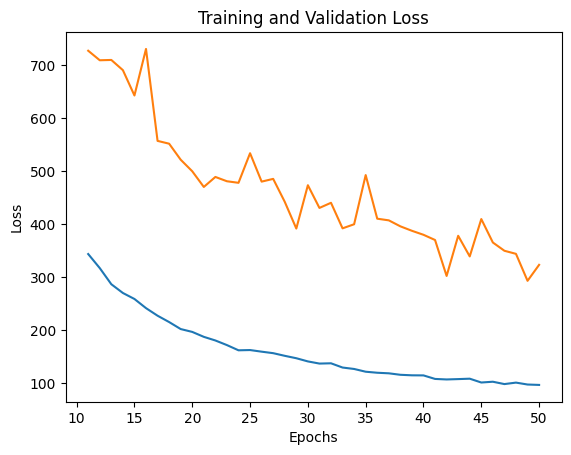

In [14]:
from matplotlib.pylab import plt

epochs = range(11, 51)

plt.plot(epochs, train_loss_list[10:], label='Training Loss')
plt.plot(epochs, eval_loss_list[10:], label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [15]:
def save_res(file_name, out):
    doc = minidom.parse(file_name)
    for i in out:
        tmp = []
        tmp.append('M')
        i = i.tolist()
        tmp.append(str(i[0]))
        tmp.append(str(i[1]))
        tmp.append("Q")
        tmp.append(str(i[4]))
        tmp.append(str(i[5]))
        tmp.append(str(i[2]))
        tmp.append(str(i[3]))
        x = doc.createElement("path")
        x.setAttribute("d" , " ".join(tmp))
        x.setAttribute("stroke" , "red")
        x.setAttribute("fill" , "none")
        doc.childNodes[0].appendChild(x)
    
    doc.writexml(open(file_name[:-4] + "_res.svg", 'w'))
    

In [19]:
names = onlyfiles_pants[:100] + onlyfiles_skirt[:100]

for name in names:
    a = get_data_from_spec(name)
    data = torch.tensor(a[0]).to(device)
    edge_index = torch.tensor(a[1]).to(device).permute(1,0)
    
    out = model(data, edge_index)

    save_res(name,out)

In [52]:
for i in out:
    print(i.tolist())

[59.52334213256836, 346.2449035644531, 158.48031616210938, 345.9590759277344, 111.01795196533203, 345.2615661621094]
[168.86642456054688, 355.6022033691406, 167.94105529785156, 53.63191223144531, 197.25413513183594, 83.80696105957031]
[160.8979949951172, 60.74776077270508, 87.47350311279297, 65.3702163696289, 126.03679656982422, 63.35658645629883]
[82.98078155517578, 62.74359893798828, 57.366886138916016, 156.6012725830078, 98.33832550048828, 142.36863708496094]
[62.356666564941406, 146.03050231933594, 62.18388748168945, 343.443359375, 83.97171783447266, 159.24220275878906]
[230.0357208251953, 355.7780456542969, 303.3335876464844, 354.97943115234375, 264.552734375, 353.0500183105469]
[290.0574645996094, 357.5351257324219, 290.7722473144531, 152.25856018066406, 277.0556640625, 165.2147979736328]
[299.2213439941406, 155.0422821044922, 272.01495361328125, 61.996864318847656, 259.470458984375, 142.06373596191406]
[271.3050537109375, 64.16558074951172, 234.40054321289062, 53.80352020263672,

In [91]:
print(onlyfiles[0][:-4] + "_res.svg")

pants_straight_sides_1000\pants_straight_sides_02LK7BEVSJ\pants_straight_sides_02LK7BEVSJ_pattern_res.svg


In [ ]:
def save_res(file_name, out):
    doc = minidom.parse(file_name)
    for i in out:
        tmp = []
        tmp.append('M')
        i = i.tolist()
        tmp.append(str(i[0]))
        tmp.append(str(i[1]))
        tmp.append("Q")
        tmp.append(str(i[4]))
        tmp.append(str(i[5]))
        tmp.append(str(i[2]))
        tmp.append(str(i[3]))
        x = doc.createElement("path")
        x.setAttribute("d" , " ".join(tmp))
        x.setAttribute("stroke" , "red")
        x.setAttribute("fill" , "none")
        doc.childNodes[0].appendChild(x)
    
    doc.writexml(open(file_name[:-4] + "_res.svg", 'w'))
    

In [85]:
doc = minidom.parse(onlyfiles[0])
print(doc.toprettyxml())
for i in out:
    tmp = []
    tmp.append('M')
    i = i.tolist()
    tmp.append(str(i[0]))
    tmp.append(str(i[1]))
    tmp.append("Q")
    tmp.append(str(i[4]))
    tmp.append(str(i[5]))
    tmp.append(str(i[2]))
    tmp.append(str(i[3]))
    x = doc.createElement("path")
    x.setAttribute("d" , " ".join(tmp))
    x.setAttribute("stroke" , "red")
    x.setAttribute("fill" , "none")
    doc.childNodes[0].appendChild(x)
print(doc.toprettyxml())

    

<?xml version="1.0" ?>
<svg xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink" baseProfile="tiny" height="417px" version="1.2" width="660px">
	
  
	<defs/>
	
  
	<path d="M 60 357 L 165 357 Q 194.7 89.69999999999999 165 60 L 90 60 Q 105.9 144.0 60 156 Q 80.1 166.05 60 357 z" fill="rgb(255,217,194)" stroke="black"/>
	
  
	<text fill="rgb(9,33,173)" font-size="25" x="83.0" y="201.0">Rback</text>
	
  
	<path d="M 225 357 L 300 357 Q 279.9 166.05 300 156 Q 258.9 142.5 270 60 L 225 60 Q 195.3 89.7 225 357 z" fill="rgb(255,217,194)" stroke="black"/>
	
  
	<text fill="rgb(9,33,173)" font-size="25" x="239.0" y="201.0">Rfront</text>
	
  
	<path d="M 360 357 L 465 357 Q 444.9 166.05 465 156 Q 419.1 144.0 435 60 L 360 60 Q 330.3 89.7 360 357 z" fill="rgb(255,217,194)" stroke="black"/>
	
  
	<text fill="rgb(9,33,173)" font-size="25" x="392.0" y="201.0">Lback</text>
	
  
	<path d="M 525 357 L 600 357 Q 629.7 89.69999999999999 6

In [86]:
doc.writexml(open("tmp.svg", 'w'))

In [65]:
x = doc.createElement("path")
x.setAttribute("d" , "abc")
doc.childNodes[0].appendChild(x)
print(doc.toprettyxml())

<?xml version="1.0" ?>
<svg xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink" baseProfile="tiny" height="417px" version="1.2" width="660px">
	
  
	<defs/>
	
  
	<path d="M 60 357 L 165 357 Q 194.7 89.69999999999999 165 60 L 90 60 Q 105.9 144.0 60 156 Q 80.1 166.05 60 357 z" fill="rgb(255,217,194)" stroke="black"/>
	
  
	<text fill="rgb(9,33,173)" font-size="25" x="83.0" y="201.0">Rback</text>
	
  
	<path d="M 225 357 L 300 357 Q 279.9 166.05 300 156 Q 258.9 142.5 270 60 L 225 60 Q 195.3 89.7 225 357 z" fill="rgb(255,217,194)" stroke="black"/>
	
  
	<text fill="rgb(9,33,173)" font-size="25" x="239.0" y="201.0">Rfront</text>
	
  
	<path d="M 360 357 L 465 357 Q 444.9 166.05 465 156 Q 419.1 144.0 435 60 L 360 60 Q 330.3 89.7 360 357 z" fill="rgb(255,217,194)" stroke="black"/>
	
  
	<text fill="rgb(9,33,173)" font-size="25" x="392.0" y="201.0">Lback</text>
	
  
	<path d="M 525 357 L 600 357 Q 629.7 89.69999999999999 6